# Preprocessing Pipeline

This notebook applies the preprocessing steps identified in EDA (see `proposed_approach.md` §4):

1. Strip HTML tags (`<h>` etc.) and decode HTML entities (`&amp;` → `&`, `&gt;` → `>`)
2. Normalise whitespace and smart quotes
3. Remove empty / near-empty samples (< 3 tokens)
4. Optionally: entity masking (replace named entities with type tokens)
5. Keyword-stratified train/val/test split

In [1]:
from utils import *
import matplotlib.pyplot as plt
import numpy as np

/workspace/PCL-70016/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATH = "Dont_Patronize_Me_Trainingset/dontpatronizeme_pcl.tsv"
raw = load_dataset(DATA_PATH)
print(f"Raw dataset: {len(raw)} samples")

Raw dataset: 10468 samples


## Step 1: Text Cleaning

Apply `clean_text()` to every sample: strip HTML tags, decode HTML entities, normalise quotes/dashes, collapse whitespace.

In [3]:
# Demonstrate cleaning on a few affected examples
demo_ids = []
for item in raw:
    if '<h>' in item.text or '&amp;' in item.text or '&gt;' in item.text:
        demo_ids.append(item)
    if len(demo_ids) >= 5:
        break

for item in demo_ids:
    cleaned = clean_text(item.text)
    print(f"par_id={item.par_id}")
    print(f"  BEFORE: {item.text[:120]}")
    print(f"  AFTER:  {cleaned[:120]}")
    print()

par_id=16
  BEFORE: Apart from Pakistan and hosts England , Bangladesh disabled cricket team will also participate in the tournament . <h> S
  AFTER:  Apart from Pakistan and hosts England , Bangladesh disabled cricket team will also participate in the tournament . Shahi

par_id=38
  BEFORE: Rizvi : There will be no joy this Eid <h> ' The citizens of this nation are becoming hopeless '
  AFTER:  Rizvi : There will be no joy this Eid ' The citizens of this nation are becoming hopeless '

par_id=55
  BEFORE: Over the past 15 years , the show has handed over more than $50 million to the Mustard Seed Communities to assist with t
  AFTER:  Over the past 15 years , the show has handed over more than $50 million to the Mustard Seed Communities to assist with t

par_id=56
  BEFORE: People who are homeless , those who were once homeless , those working with the homeless and concerned New Zealanders ar
  AFTER:  People who are homeless , those who were once homeless , those working with the home

## Step 2: Filter Short/Empty Samples

Remove samples with fewer than 3 regex tokens after cleaning. The EDA found empty strings and single-word entries like "refugees" that lack sufficient context for classification.

In [4]:
# Apply full pipeline (clean + filter, without entity masking for now)
cleaned = preprocess_items(raw, min_tokens=3, do_entity_mask=False)

Preprocessing: 10468 → 10465 samples (dropped 1 empty, 2 short [<3 tokens])


In [5]:
# Verify: class distribution is preserved after filtering
_, raw_binary = label_stats(raw)
_, clean_binary = label_stats(cleaned)

print("Class distribution comparison:")
print(f"  {'':15s} {'Raw':>8s} {'Cleaned':>8s}")
for lbl in [PCLBinaryLabel.NO_PCL, PCLBinaryLabel.PCL]:
    print(f"  {lbl.name:15s} {raw_binary[lbl]:>8,} {clean_binary[lbl]:>8,}")

raw_rate = raw_binary[PCLBinaryLabel.PCL] / sum(raw_binary.values())
clean_rate = clean_binary[PCLBinaryLabel.PCL] / sum(clean_binary.values())
print(f"\n  PCL rate: {raw_rate:.2%} (raw) → {clean_rate:.2%} (cleaned)")

Class distribution comparison:
                       Raw  Cleaned
  NO_PCL             9,475    9,472
  PCL                  993      993

  PCL rate: 9.49% (raw) → 9.49% (cleaned)


After cleaning — Min: 3, Max: 820, Mean: 43.9, p95: 92, p99: 129


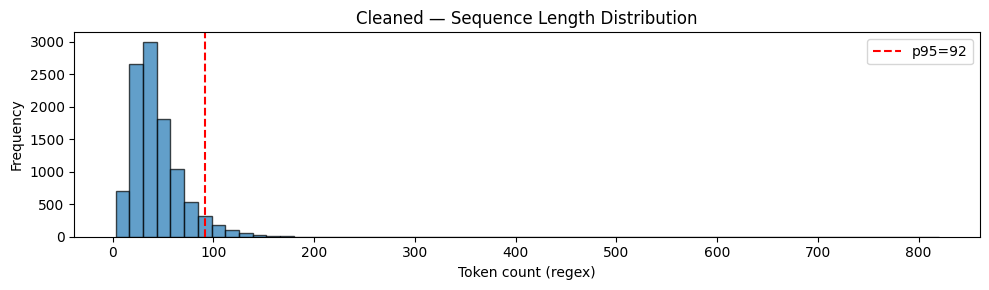

In [6]:
# Verify: length distribution after cleaning
dist = length_distribution(cleaned, TOKENISERS["regex"])
print(f"After cleaning — Min: {dist['min']}, Max: {dist['max']}, "
      f"Mean: {dist['mean']:.1f}, p95: {dist['p95']}, p99: {dist['p99']}")

fig, ax = plt.subplots(figsize=(10, 3))
ax.hist(dist['lengths'], bins=60, edgecolor='black', alpha=0.7)
ax.axvline(dist['p95'], color='red', linestyle='--', label=f"p95={dist['p95']}")
ax.set_xlabel('Token count (regex)')
ax.set_ylabel('Frequency')
ax.set_title('Cleaned — Sequence Length Distribution')
ax.legend()
plt.tight_layout()
plt.show()

## Step 3: Entity Masking (Optional)

Replace named entities with type tokens (e.g. `Libya` → `[GPE]`, `Sean Spicer` → `[PERSON]`). This forces the model to learn tonal patterns rather than memorising specific names.

We produce **two** versions of the dataset — with and without masking — so we can compare during training.

In [7]:
# Demonstrate entity masking
demo_texts = [
    "Pope Francis washed and kissed the feet of Muslim refugees in Rome.",
    "Sean Spicer said the White House would help homeless people in Libya.",
    "The United States government announced new policies for immigrant families.",
]
for t in demo_texts:
    print(f"  BEFORE: {t}")
    print(f"  AFTER:  {mask_entities(t)}")
    print()

  BEFORE: Pope Francis washed and kissed the feet of Muslim refugees in Rome.
  AFTER:  Pope [PERSON] washed and kissed the feet of [NORP] refugees in [GPE].

  BEFORE: Sean Spicer said the White House would help homeless people in Libya.
  AFTER:  [PERSON] said [ORG] would help homeless people in [GPE].

  BEFORE: The United States government announced new policies for immigrant families.
  AFTER:  [GPE] government announced new policies for immigrant families.



In [8]:
# Build entity-masked version (this takes a few minutes — spaCy NER on full corpus)
cleaned_masked = preprocess_items(raw, min_tokens=3, do_entity_mask=True)

Preprocessing: 10468 → 10465 samples (dropped 1 empty, 2 short [<3 tokens])


In [9]:
# Side-by-side comparison
for i in range(5):
    print(f"[{i}] Original:  {cleaned[i].text[:100]}")
    print(f"    Masked:    {cleaned_masked[i].text[:100]}")
    print()

[0] Original:  In Libya today , there are countless number of Ghanaian and Nigerian immigrants . These are the two 
    Masked:    In [GPE] [DATE] , there are countless number of [NORP] and [NORP] immigrants . These are the [CARDIN

[1] Original:  "White House press secretary Sean Spicer said that the focus of immigration actions would be illegal
    Masked:    "[ORG] press secretary [PERSON] said that the focus of immigration actions would be illegal immigran

[2] Original:  Council customers only signs would be displayed . Two of the spaces would be reserved for disabled p
    Masked:    Council customers only signs would be displayed . [CARDINAL] of the spaces would be reserved for dis

[3] Original:  """ Just like we received migrants fleeing El Salvador and Guatemala in the ' 80s and ' 90s , just l
    Masked:    """ Just like we received migrants fleeing [GPE] and [GPE] in [DATE] , just like we 've seen [CARDIN

[4] Original:  To bring down high blood sugar levels , insulin needs

## Step 4: Official Train/Dev Split

The dataset authors provide official SemEval train/dev par_id lists in `Dont_Patronize_Me_Trainingset/practice splits/`. We use these as the base split. Cross-validation folds will be created within the train split during training.

In [10]:
# Use the official SemEval train/dev par_id lists
splits = load_official_splits(cleaned)

  (!) 2 par_ids in train CSV not found in cleaned items — excluded
  (!) 2 par_ids in dev CSV not found in cleaned items — excluded
Official split: train=8373, dev=2092
  train: 794/8373 PCL (9.5%)
  dev: 199/2092 PCL (9.5%)


In [11]:
# Verify keyword distribution is balanced across splits
from collections import Counter

print(f"{'Keyword':20s} {'Train':>8s} {'Dev':>8s}")
print("-" * 40)
kw_train = Counter(x.keyword for x in splits['train'])
kw_dev   = Counter(x.keyword for x in splits['dev'])

for kw in sorted(kw_train.keys()):
    print(f"  {kw:18s} {kw_train[kw]:>8,} {kw_dev.get(kw,0):>8,}")

Keyword                 Train      Dev
----------------------------------------
  disabled                834      194
  homeless                865      212
  hopeless                787      216
  immigrant               843      218
  in-need                 856      226
  migrant                 882      206
  poor-families           719      190
  refugee                 879      188
  vulnerable              871      209
  women                   837      233


In [12]:
# Verify PCL rate per keyword is consistent across splits
print(f"{'Keyword':20s} {'Train PCL%':>10s} {'Dev PCL%':>10s}")
print("-" * 45)
for kw in sorted(kw_train.keys()):
    rates = []
    for split_name in ['train', 'dev']:
        kw_items = [x for x in splits[split_name] if x.keyword == kw]
        pcl_rate = sum(1 for x in kw_items if x.is_pcl) / len(kw_items) * 100 if kw_items else 0
        rates.append(pcl_rate)
    print(f"  {kw:18s} {rates[0]:>9.1f}% {rates[1]:>9.1f}%")

Keyword              Train PCL%   Dev PCL%
---------------------------------------------
  disabled                 8.0%       7.2%
  homeless                17.2%      13.7%
  hopeless                12.5%      12.0%
  immigrant                2.7%       3.2%
  in-need                 16.7%      14.6%
  migrant                  3.5%       2.4%
  poor-families           15.6%      20.0%
  refugee                  8.3%       6.9%
  vulnerable               6.9%       9.6%
  women                    4.5%       6.0%


## Step 5: Save Preprocessed Splits

Save the splits to disk so the training notebook can load them directly without re-running preprocessing.

In [13]:
import json, os

OUT_DIR = "preprocessed"
os.makedirs(OUT_DIR, exist_ok=True)

def items_to_records(items):
    """Convert PCLItems to JSON-serialisable dicts."""
    return [{
        "par_id": x.par_id,
        "art_id": x.art_id,
        "keyword": x.keyword,
        "country_code": x.country_code,
        "text": x.text,
        "label_ordinal": x.label_ordinal,
        "label_binary": x.label_binary.value,
    } for x in items]

# Save non-masked splits: train.json and val.json (official dev split)
save_map = {"train": "train", "dev": "val"}
for split_name, file_stem in save_map.items():
    path = os.path.join(OUT_DIR, f"{file_stem}.json")
    with open(path, "w") as f:
        json.dump(items_to_records(splits[split_name]), f)
    print(f"Saved {path}: {len(splits[split_name])} samples")

# Save entity-masked versions
splits_masked = load_official_splits(cleaned_masked)
for split_name, file_stem in save_map.items():
    path = os.path.join(OUT_DIR, f"{file_stem}_masked.json")
    with open(path, "w") as f:
        json.dump(items_to_records(splits_masked[split_name]), f)
    print(f"Saved {path}: {len(splits_masked[split_name])} samples")


Saved preprocessed/train.json: 8373 samples
Saved preprocessed/val.json: 2092 samples
  (!) 2 par_ids in train CSV not found in cleaned items — excluded
  (!) 2 par_ids in dev CSV not found in cleaned items — excluded
Official split: train=8373, dev=2092
  train: 794/8373 PCL (9.5%)
  dev: 199/2092 PCL (9.5%)
Saved preprocessed/train_masked.json: 8373 samples


Saved preprocessed/val_masked.json: 2092 samples


## Step 6: Official Test Set

Parse `task4_test.tsv` (the unlabelled competition test set, 3,832 entries), apply the same text cleaning pipeline, and save as `test.json` and `test_masked.json`.

Columns in the TSV: `row_id | art_id | keyword | country_code | text` (no labels).


In [14]:
TEST_TSV = "Dont_Patronize_Me_Trainingset/TEST/task4_test.tsv"

def load_official_test(path: str) -> list:
    """Parse task4_test.tsv into JSON-serialisable dicts, preserving TSV row order.

    Columns: row_id (t_N) | art_id (@@int) | keyword | country_code | text
    Labels are absent — label_ordinal and label_binary are set to -1.

    No rows are dropped: test.txt must have exactly one prediction per input line.
    """
    records = []
    with open(path) as f:
        for line in f:
            parts = line.rstrip("\n").split("\t")
            if len(parts) < 5:
                continue
            row_id, raw_art_id, keyword, country_code = parts[0], parts[1], parts[2], parts[3]
            text = "\t".join(parts[4:])  # text may contain tabs

            art_id_str = raw_art_id.lstrip("@")
            try:
                art_id = int(art_id_str)
            except ValueError:
                art_id = 0

            cleaned = clean_text(text)
            # Do NOT filter short texts — every row must produce a prediction line

            records.append({
                "par_id": row_id,          # row string id (t_0, t_1, ...)
                "art_id": art_id,
                "keyword": keyword.strip(),
                "country_code": country_code.strip(),
                "text": cleaned,
                "label_ordinal": -1,       # unlabelled
                "label_binary": -1,        # unlabelled
            })
    return records

test_records = load_official_test(TEST_TSV)
print(f"Official test set: {len(test_records)} samples (expected 3832)")

# Save plain version
test_path = os.path.join(OUT_DIR, "test.json")
with open(test_path, "w") as f:
    json.dump(test_records, f)
print(f"Saved {test_path}")

# Save entity-masked version
test_records_masked = []
for rec in test_records:
    masked = dict(rec)
    masked["text"] = mask_entities(rec["text"])
    test_records_masked.append(masked)

test_masked_path = os.path.join(OUT_DIR, "test_masked.json")
with open(test_masked_path, "w") as f:
    json.dump(test_records_masked, f)
print(f"Saved {test_masked_path}")


Official test set: 3832 samples (expected 3832)
Saved preprocessed/test.json
Saved preprocessed/test_masked.json


In [15]:
# Convenience: loader for preprocessed splits (for use in training notebook)
def load_split(path: str) -> list:
    """Load a preprocessed JSON split back into PCLItem objects."""
    with open(path) as f:
        records = json.load(f)
    return [
        PCLItem(
            par_id=r["par_id"],
            art_id=r["art_id"],
            keyword=r["keyword"],
            country_code=r["country_code"],
            text=r["text"],
            label_ordinal=r["label_ordinal"],
            label_binary=PCLBinaryLabel(r["label_binary"]),
        )
        for r in records
    ]

# Quick sanity check
train_reload = load_split(os.path.join(OUT_DIR, "train.json"))
val_reload   = load_split(os.path.join(OUT_DIR, "val.json"))
print(f"Reloaded train: {len(train_reload)} samples, first text: \"{train_reload[0].text[:60]}...\"")
print(f"Reloaded val:   {len(val_reload)} samples, first text: \"{val_reload[0].text[:60]}...\"")
print(f"Test (raw dicts): {len(json.load(open(os.path.join(OUT_DIR, 'test.json'))))} samples")


Reloaded train: 8373 samples, first text: "The scheme saw an estimated 150,000 children from poor famil..."
Reloaded val:   2092 samples, first text: "We also know that they can benefit by receiving counseling f..."
Test (raw dicts): 3832 samples


## Summary

| Step | Effect |
|---|---|
| HTML stripping + entity decoding | Removed `<h>` tags (401 docs) and decoded `&amp;`/`&gt;` (78 docs) |
| Whitespace/quote normalisation | Standardised smart quotes and collapsed multi-spaces |
| Short sample filtering (< 3 tokens) | Removed empty strings and single-word entries |
| Entity masking (optional) | Replaced named entities with `[TYPE]` tokens — alternate dataset version |
| Official train/val split | Used SemEval-provided par_id lists: `train_semeval_parids-labels.csv` → `train.json`, `dev_semeval_parids-labels.csv` → `val.json` |
| Official test set | Parsed and cleaned `task4_test.tsv` (3,832 unlabelled entries) → `test.json` |

Preprocessed data saved to `preprocessed/`:
- `train.json` / `train_masked.json` — official SemEval training split (8,373 samples, labelled)
- `val.json` / `val_masked.json` — official SemEval dev split (2,092 samples, labelled)
- `test.json` / `test_masked.json` — official competition test set (3,832 samples, **no labels**)
